# Model Architecture Point of Interest Experiments

Initial setup:

In [1]:
import os

import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

In [2]:
from constants import RETRAIN_MODEL, ALPHA, BETA
from data import get_dataset
from information_gain import calculate_information_gains
from model_structures import ModelClasses, CNNModel
from trainer import train_model, make_model

In [3]:
def init():
    print(f'TensorFlow version: {tf.__version__}')
    tf.config.run_functions_eagerly(True)

In [4]:
init()

TensorFlow version: 2.11.0


In [5]:
train_ds, test_ds = get_dataset()

In [6]:
def get_trained_model(model_cls):
    model, trained = make_model(model_cls)
    if RETRAIN_MODEL or not trained:
        train_model(model, train_ds, test_ds)
    return model

In [7]:
def create_file_name(model_cls, alpha=ALPHA, beta=BETA):
    return f'./data/{model_cls.__name__.lower()}_info_gain_matrix_{alpha}_{beta}.npy'

def load_info_gain_matrix(model_cls, alpha=ALPHA, beta=BETA):
    return np.load(create_file_name(model_cls, alpha, beta))

In [11]:
for model_cls in ModelClasses:
    fname = create_file_name(model_cls)
    theta_fname = create_file_name(model_cls, 1, 0)
    inpt_fname = create_file_name(model_cls, 0, 1)

    if not os.path.isfile(theta_fname) or not os.path.isfile(inpt_fname):
        print(f'Running {model_cls.__name__.lower()}')
        model = get_trained_model(model_cls)
        info_gain_matrix, theta_matrix, inpt_matrix = calculate_information_gains(model, test_ds)
        with open(fname, 'wb') as f:
            np.save(f, info_gain_matrix)
        with open(theta_fname, 'wb') as f:
            np.save(f, theta_matrix)
        with open(inpt_fname, 'wb') as f:
            np.save(f, inpt_matrix)
    elif not os.path.isfile(fname):
        theta_matrix = load_info_gain_matrix(model_cls, 1, 0)
        inpt_matrix = load_info_gain_matrix(model_cls, 0, 1)
        with open(fname, 'wb') as f:
            info_gain_matrix = ALPHA * theta_matrix + BETA * inpt_matrix
            np.save(f, info_gain_matrix)
    else:
        print(f'File for {model_cls.__name__.lower()} already exists')

File for cnnmodel already exists
File for cnnmodel2 already exists
File for densemodel already exists
Running densemodel2


100%|██████████| 313/313 [24:36<00:00,  4.72s/it]


In [12]:
alpha = ALPHA
beta = BETA
info_gain_matricies = [load_info_gain_matrix(model_cls, alpha, beta) for model_cls in ModelClasses]


Information Gain Saliency Maps


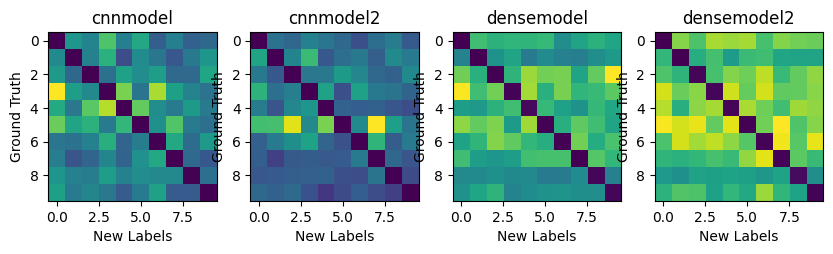

In [13]:
fig, axes = plt.subplots(1, len(ModelClasses), figsize=(10, 10))

for i in range(len(ModelClasses)):
    axes[i].imshow(info_gain_matricies[i])
    axes[i].set_title(f'{ModelClasses[i].__name__.lower()}')
    axes[i].set_xlabel('New Labels')
    axes[i].set_ylabel('Ground Truth')

print('Information Gain Saliency Maps')

Normalized Information Gain Saliency Maps


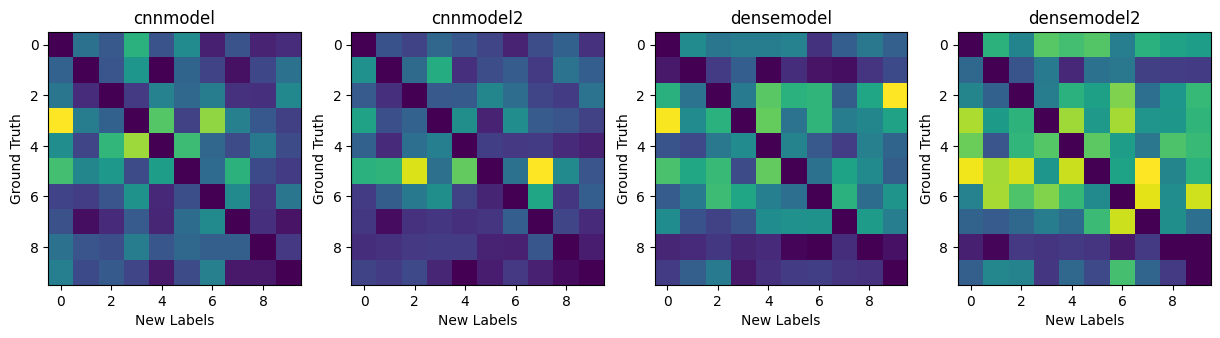

In [16]:
fig, axes = plt.subplots(1, len(ModelClasses), figsize=(15, 10))

for i in range(len(ModelClasses)):
    min_idx = min(
        [(a, b) for a in range(10) for b in range(10)],
        key=lambda idx: float('inf') if idx[0] == idx[1] else info_gain_matricies[i][idx[0], idx[1]]
    )
    max_idx = max(
        [(a, b) for a in range(10) for b in range(10)],
        key=lambda idx: float('-inf') if idx[0] == idx[1] else info_gain_matricies[i][idx[0], idx[1]]
    )
    min_val = info_gain_matricies[i][min_idx[0], min_idx[1]]
    max_val = info_gain_matricies[i][max_idx[0], max_idx[1]]

    img = 255 * (info_gain_matricies[i] - min_val) / (max_val - min_val)
    for j in range(10):
        img[j, j] = 0

    axes[i].imshow(img)
    axes[i].set_title(f'{ModelClasses[i].__name__.lower()}')
    axes[i].set_xlabel('New Labels')
    axes[i].set_ylabel('Ground Truth')

print('Normalized Information Gain Saliency Maps')

Normalized Information Gain Saliency Maps Differences


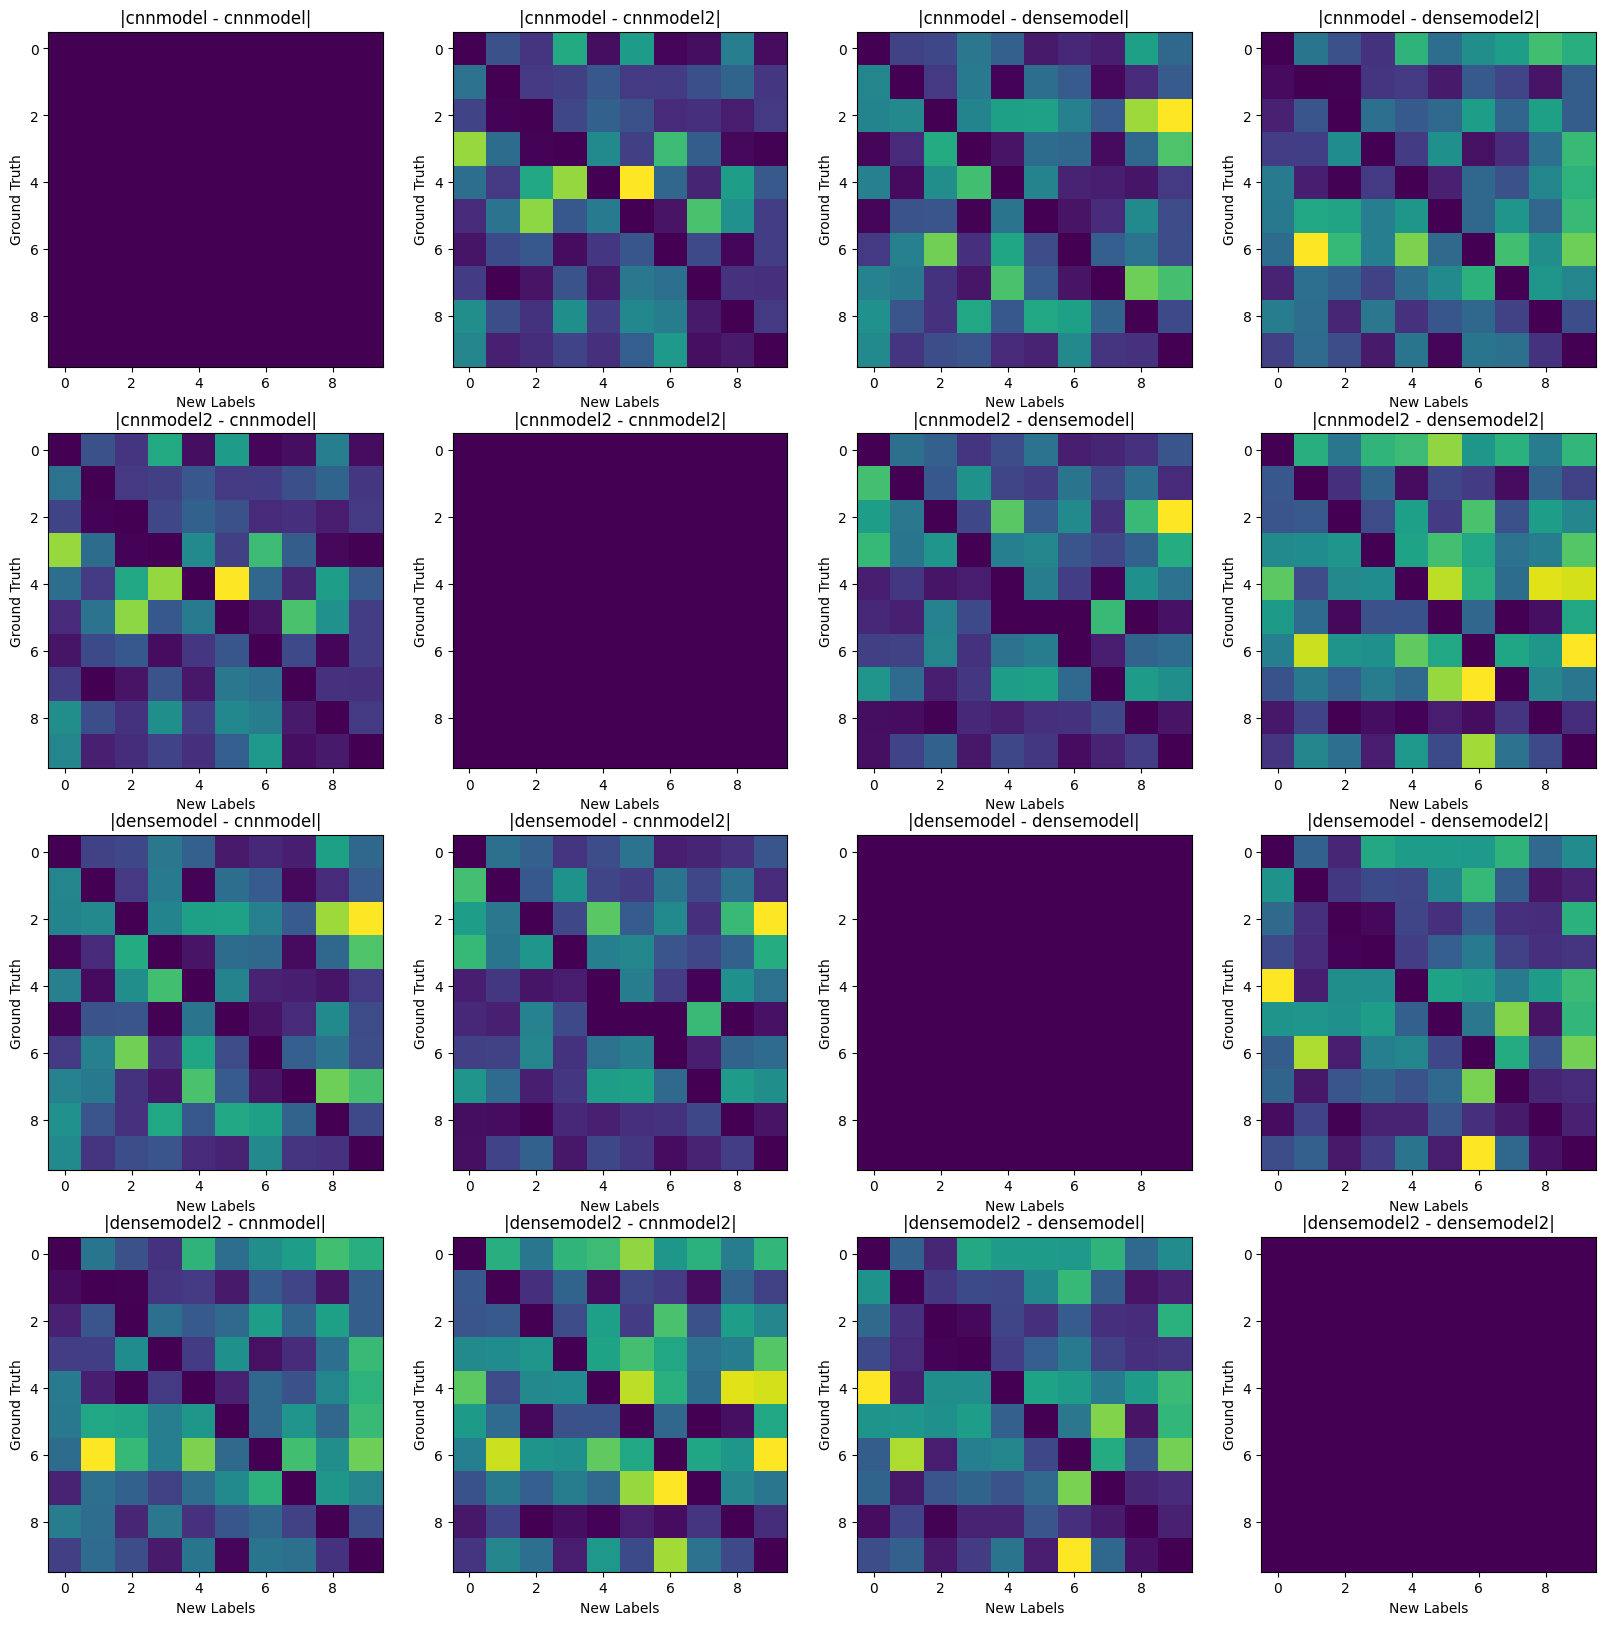

In [15]:
fig, axes = plt.subplots(len(ModelClasses), len(ModelClasses), figsize=(20, 20))

imgs = []
for i in range(len(ModelClasses)):
    min_idx = min(
        [(a, b) for a in range(10) for b in range(10)],
        key=lambda idx: float('inf') if idx[0] == idx[1] else info_gain_matricies[i][idx[0], idx[1]]
    )
    max_idx = max(
        [(a, b) for a in range(10) for b in range(10)],
        key=lambda idx: float('-inf') if idx[0] == idx[1] else info_gain_matricies[i][idx[0], idx[1]]
    )
    min_val = info_gain_matricies[i][min_idx[0], min_idx[1]]
    max_val = info_gain_matricies[i][max_idx[0], max_idx[1]]

    img = 255 * (info_gain_matricies[i] - min_val) / (max_val - min_val)
    for k in range(10):
        img[k, k] = 0
    imgs.append(img)

for i in range(len(ModelClasses)):
    for j in range(len(ModelClasses)):
        axes[i][j].imshow(abs(imgs[i] - imgs[j]))
        axes[i][j].set_title(f'|{ModelClasses[i].__name__.lower()} - {ModelClasses[j].__name__.lower()}|')
        axes[i][j].set_xlabel('New Labels')
        axes[i][j].set_ylabel('Ground Truth')

print('Normalized Information Gain Saliency Maps Differences')